# Linear Bivariate BMM with SAMBA toy models : switchcos mixing - bilby constrained priors

The best way to learn Taweret is to use it. You can run, modify and experiment with this notebook [here.](https://mybinder.org/v2/gh/danOSU/Taweret/c2d8fd3ce3d74a5891d51adb5afc0afa0b503127?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FLinear_BMM_with_switchcos_function_for_SAMBA_models_Bilby_constrained_prior.ipynb)


This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

Author : Dan Liyanage 

Date : 11/10/2022

More about SAMBA toy models can be found in [Uncertainties here, there, and everywhere: interpolating between small- and large-g expansions using Bayesian Model Mixing](https://arxiv.org/abs/2206.04116)



**Steps for Bayesian Model Mixing with Taweret**

    1. Define your models using BayesModel class in `Taweret.core.bayesmodel` (Only if you want to bring in your own models)
    2. Choose a Mixing method (Avilable mixing methods can be found in Taweret/mix)
    3. Find the posterior for the mixture weights (parameters in the mixture function) and/or model parameters by training the mixed model. 
    4. Make predictions! 

In [1]:
import sys

# You will have to change the following imports depending on where you have 
# the packages installed
# If using binder please uncomment the followings.
#sys.path.append("/home/jovyan/")
#sys.path.append("/home/jovyan/subpackages/SAMBA")

sys.path.append("/Users/dananjayaliyanage/temp2/Taweret")
sys.path.append("/Users/dananjayaliyanage/temp2/Taweret/subpackages/SAMBA")

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# To define priors. (uncoment if not using default priors)
import bilby

# For other operations
import numpy as np

## 1. Get toy models and the pseudo-experimental data

In [2]:
# Toy models from SAMBA
from Taweret.models import samba_models as toy_models

m1 = toy_models.Loworder(2, 'uninformative')
m2 = toy_models.Highorder(2, 'uninformative')
truth = toy_models.TrueModel()
exp = toy_models.Data()

In [3]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.evaluate(plot_g)
m2_prediction = m2.evaluate(plot_g)
true_output = truth.evaluate(plot_g)
exp_data= exp.evaluate(g,error = 0.01)

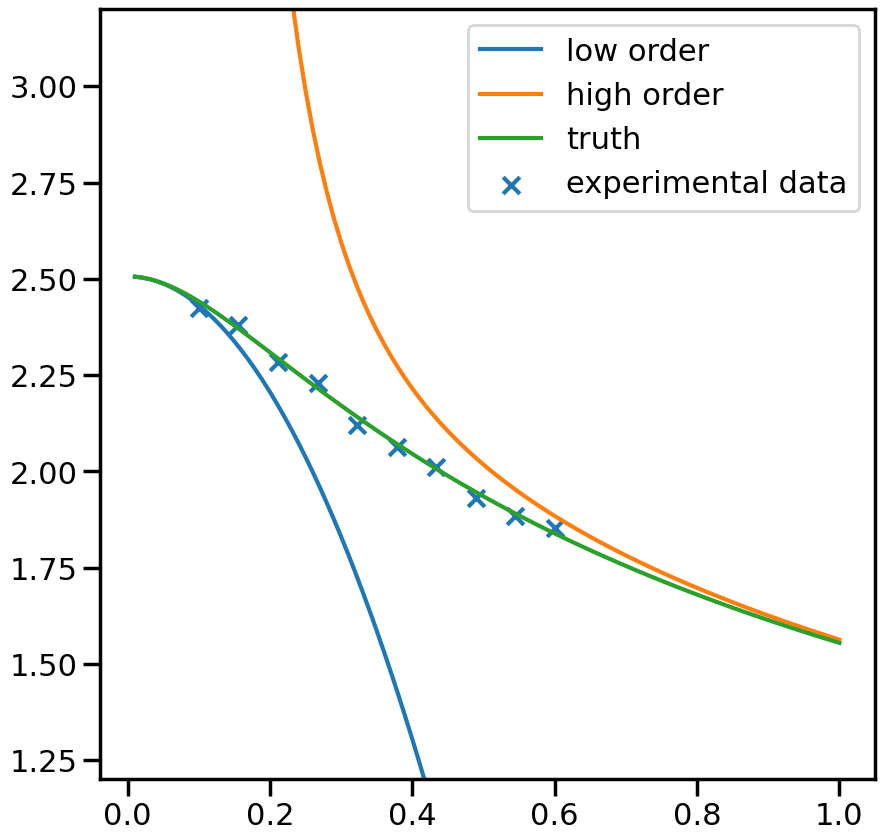

In [4]:

fig, ax_f = plt.subplots(figsize=(10,10))
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g,exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

##  2. Choose a Mixing method

In [5]:
# Mixing method
from Taweret.mix.bivariate_linear import BivariateLinear as BL

models= {'low_order':m1,'high_order':m2}
mix_model = BL(models_dic=models, method='switchcos') 

switchcos mixing function has 3                   free parameter(s)
To change the prior use `set_prior` method


#####  Need to speceify a constained prior for switchcos. g1 < g3 < g2
We follow Bilby documentation on how to specefy a prior with constraints
https://lscsoft.docs.ligo.org/bilby/prior.html#prior-constraints

In [6]:
#uncoment to change the prior from the default
def convert_x_y_to_z(parameters):
    """
    Function to convert between sampled parameters and constraint parameter.

    Parameters
    ----------
    parameters: dict
        Dictionary containing sampled parameter values, 'theta_0', 'theta_1', 'theta_2'.

    Returns
    -------
    dict: Dictionary with constraint parameter 'z_0, z_1' added.
    """
    converted_parameters = parameters.copy()
    converted_parameters['z_0'] = parameters['switchcos_2'] - parameters['switchcos_0']
    converted_parameters['z_1'] = parameters['switchcos_1'] - parameters['switchcos_2']
    return converted_parameters

from bilby.core.prior import PriorDict, Uniform, Constraint, TruncatedNormal

priors = PriorDict(conversion_function=convert_x_y_to_z)
# priors['theta_0'] = Uniform(minimum=0.0, maximum=0.3)
# priors['theta_1'] = Uniform(minimum=0.0, maximum=0.55)
# priors['theta_2'] = Uniform(minimum=0.0, maximum=0.8)

priors['switchcos_0'] = TruncatedNormal(0.1, 0.05, 0.01, 0.3)
priors['switchcos_1'] = TruncatedNormal(0.6, 0.05, 0, 0.8)
priors['switchcos_2'] = TruncatedNormal(0.4, 0.05, 0, 0.55)
priors['z_0'] = Constraint(minimum=0, maximum=1)
priors['z_1'] = Constraint(minimum=0, maximum=1)
mix_model.set_prior(priors)

{'switchcos_0': TruncatedNormal(mu=0.1, sigma=0.05, minimum=0.01, maximum=0.3, name=None, latex_label=None, unit=None, boundary=None),
 'switchcos_1': TruncatedNormal(mu=0.6, sigma=0.05, minimum=0, maximum=0.8, name=None, latex_label=None, unit=None, boundary=None),
 'switchcos_2': TruncatedNormal(mu=0.4, sigma=0.05, minimum=0, maximum=0.55, name=None, latex_label=None, unit=None, boundary=None),
 'z_0': Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None),
 'z_1': Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None)}

## 3. Train to find posterior

In [7]:
mix_model.prior

{'switchcos_0': TruncatedNormal(mu=0.1, sigma=0.05, minimum=0.01, maximum=0.3, name=None, latex_label=None, unit=None, boundary=None),
 'switchcos_1': TruncatedNormal(mu=0.6, sigma=0.05, minimum=0, maximum=0.8, name=None, latex_label=None, unit=None, boundary=None),
 'switchcos_2': TruncatedNormal(mu=0.4, sigma=0.05, minimum=0, maximum=0.55, name=None, latex_label=None, unit=None, boundary=None),
 'z_0': Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None),
 'z_1': Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None)}

In [8]:
y_exp = np.array(exp_data[0]).reshape(1,-1)
y_err = np.array(exp_data[1]).reshape(1,-1)
# The parameters are set to minimum values for computational ease.
# You should increase the ntemps, nwalkers and nsamples and see
# if your results are changing. If so keep increasing them
# until convergence of results. 

kwargs_for_sampler = {'sampler': 'ptemcee',
                    'ntemps': 5,
                    'nwalkers': 50,
                    'Tmax': 100,
                    'burn_in_fixed_discard': 50,
                    'nsamples': 2000,
                    'threads': 6,
                    'printdt': 60}

result = mix_model.train(x_exp=g, y_exp=exp_data[0], y_err=exp_data[1],outdir = 'outdir/samba_bivariate', 
                         label='switchcos_mix_constrained',
                         kwargs_for_sampler=kwargs_for_sampler)

15:53 bilby INFO    : Running for label 'switchcos_mix_constrained', output will be saved to 'outdir/samba_bivariate'
15:53 bilby INFO    : Search parameters:
15:53 bilby INFO    :   switchcos_0 = TruncatedNormal(mu=0.1, sigma=0.05, minimum=0.01, maximum=0.3, name=None, latex_label=None, unit=None, boundary=None)
15:53 bilby INFO    :   switchcos_1 = TruncatedNormal(mu=0.6, sigma=0.05, minimum=0, maximum=0.8, name=None, latex_label=None, unit=None, boundary=None)
15:53 bilby INFO    :   switchcos_2 = TruncatedNormal(mu=0.4, sigma=0.05, minimum=0, maximum=0.55, name=None, latex_label=None, unit=None, boundary=None)
15:53 bilby INFO    :   z_0 = Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None)
15:53 bilby INFO    :   z_1 = Constraint(minimum=0, maximum=1, name=None, latex_label=None, unit=None)
15:53 bilby INFO    : Single likelihood evaluation took 7.231e-04 s
15:53 bilby WARNING : Supplied argument 'printdt' not an argument of 'Ptemcee', removing.
15:53 bilby IN

The following settings were                     provided for sampler 
{'sampler': 'ptemcee', 'ntemps': 5, 'nwalkers': 50, 'Tmax': 100, 'burn_in_fixed_discard': 50, 'nsamples': 2000, 'threads': 6, 'printdt': 60}


15:53 bilby INFO    : Generating pos0 samples
15:53 bilby INFO    : Starting to sample


1|0:00:00|nc:1.2e+03|a0:0.20-1.00|swp:0.86-1.00|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.29ms/ev
2|0:00:00|nc:2.5e+03|a0:0.20-1.00|swp:0.88-1.00|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.29ms/ev
3|0:00:00|nc:3.8e+03|a0:0.20-0.87|swp:0.89-1.00|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.27ms/ev
4|0:00:01|nc:5.0e+03|a0:0.35-0.85|swp:0.88-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.24ms/ev
5|0:00:01|nc:6.2e+03|a0:0.40-0.88|swp:0.87-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.22ms/ev
6|0:00:01|nc:7.5e+03|a0:0.37-0.80|swp:0.88-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.22ms/ev
7|0:00:02|nc:8.8e+03|a0:0.40-0.77|swp:0.88-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.26ms/ev
8|0:00:02|nc:1.0e+04|a0:0.42-0.80|swp:0.88-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.26ms/ev
9|0:00:02|nc:1.1e+04|a0:0.44-0.76|swp:0.88-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.26ms/ev
10|0:00:03|nc:1.2e+04|a0:0.46-0.76|swp:0.88-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.21ms/ev
11|0:00:03|nc:1.4e+04|a0:0.45-0.78|swp:0.88-0.99|n:nan<2000|t!nan(+nan,+nan)|q:

15:56 bilby INFO    : Finished sampling
15:56 bilby INFO    : Writing checkpoint and diagnostics
15:56 bilby INFO    : Finished writing checkpoint
15:56 bilby INFO    : Sampling time: 0:02:56.504275
15:56 bilby INFO    : Summary of results:
nsamples: 2600
ln_noise_evidence:    nan
ln_evidence:  4.483 +/-  0.001
ln_bayes_factor:    nan +/-  0.001



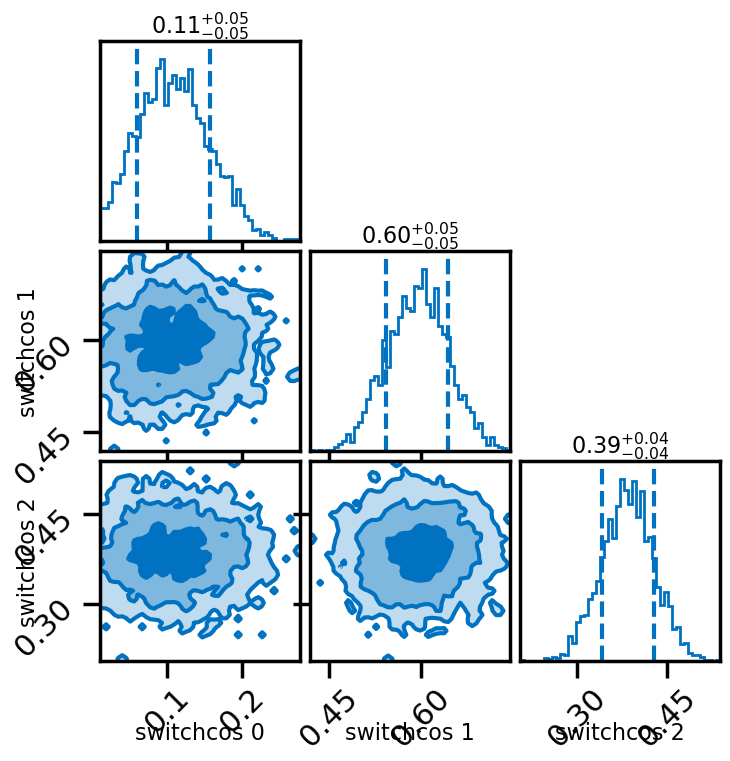

In [9]:
# Posterior of the mixing parameters. 
result.plot_corner()

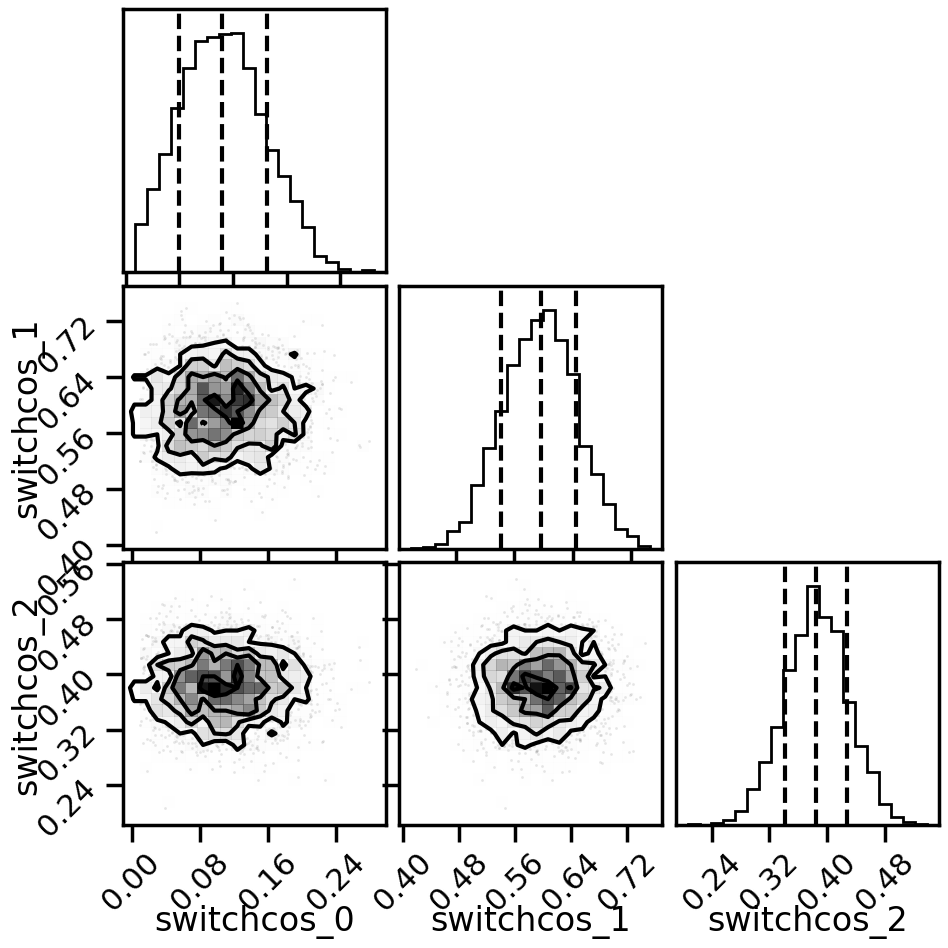

In [10]:
#corner plots
import corner
fig, axs = plt.subplots(3,3, figsize=(10,10), dpi=100)
corner.corner(mix_model.posterior,labels=['switchcos_0','switchcos_1', 'switchcos_2'],quantiles=[0.16, 0.5, 0.84],fig=fig)
plt.show()

### 4. Predictions

In [11]:
_,mean_prior,CI_prior, _ = mix_model.prior_predict(plot_g, CI=[5,20,80,95])
_,mean,CI, _ = mix_model.predict(plot_g, CI=[5,20,80,95])

(10000, 3)
using provided samples instead of posterior


In [12]:
mean.shape

(1, 100)

In [13]:
per5, per20, per80, per95 = CI
prior5, prior20, prior80, prior95 = CI_prior

In [14]:
# Map value prediction for the step mixing function parameter
map_prediction = mix_model.evaluate(mix_model.map, plot_g)

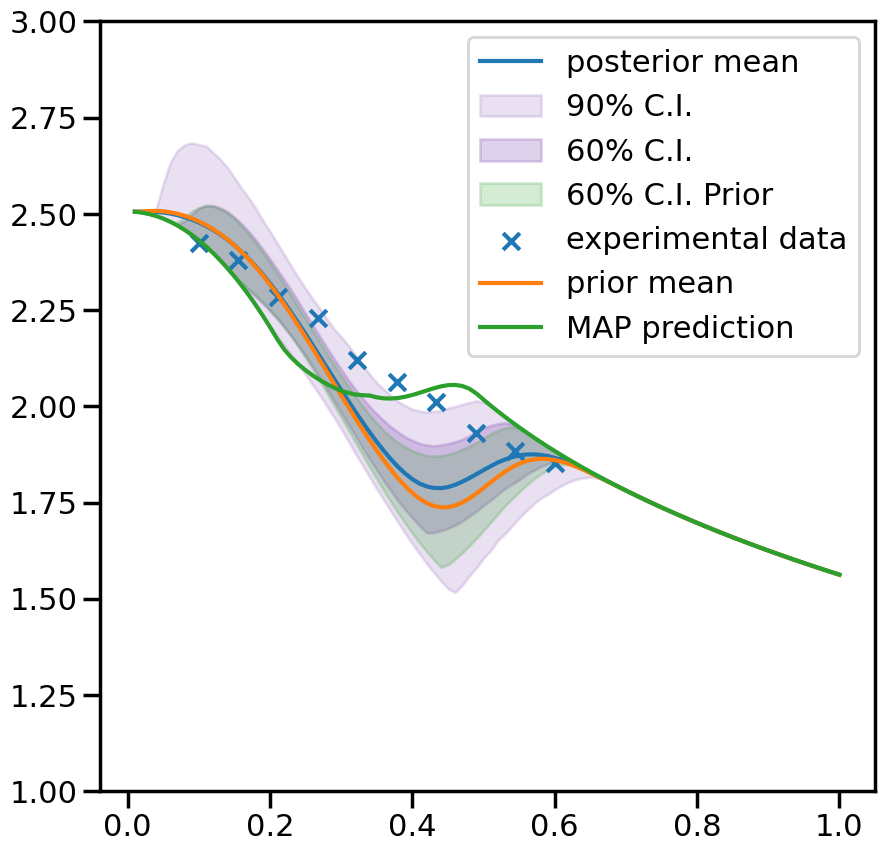

In [15]:
%matplotlib inline
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(plot_g, mean.flatten(), label='posterior mean')
ax.fill_between(plot_g,per5.flatten(),per95.flatten(),color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20.flatten(),per80.flatten(), color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.fill_between(plot_g,prior20.flatten(),prior80.flatten(),color=sns.color_palette()[2], alpha=0.2, label='60% C.I. Prior')
ax.scatter(g,exp_data[0], marker='x', label='experimental data')
ax.plot(plot_g, mean_prior.flatten(), label='prior mean')
ax.plot(plot_g, map_prediction.flatten(), label='MAP prediction')
ax.set_ybound(1,3)
ax.legend()